## Install required packages

In [1]:
!pip install -q llama_index
!pip install -q pdfplumber
!pip install -q opencv-python
!pip install -q mutagen
!pip install -q yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0

In [2]:
!pip install -q bs4

In [3]:
!pip install -q pytesseract Pillow

## Import required modules

In [4]:
from PIL import Image
import pytesseract
import requests
from bs4 import BeautifulSoup

In [5]:
import yfinance as yf
import pdfplumber
import pandas as pd
import os
import cv2
from google.colab import userdata
import matplotlib.pyplot as plt
from mutagen.mp3 import MP3
import asyncio
import requests
from datetime import date, timedelta, datetime

In [6]:
from llama_index.core.agent.workflow import (FunctionAgent,
    ReActAgent,
)
from llama_index.llms.openai import OpenAI

## Get the api_key and initialize the Chatgpt LLM model

In [7]:
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')
model=OpenAI(model="gpt-4o-mini")

## Define functions for tools to be used in the agent

In [8]:
def get_ticker(company_name):
    "Returns ticker for a company"
    yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
    params = {"q": company_name, "quotes_count": 1, "country": "India"}

    res = requests.get(url=yfinance, params=params, headers={'User-Agent': user_agent})
    data = res.json()

    ticker = data['quotes'][0]['symbol']
    return ticker

In [9]:
def get_share_trade_volume(ticker, start_date, end_date):
  "Gets share traded volume traded for a ticker for a given date"
  end_date=(datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
  print(start_date)
  print(end_date)
  data = yf.download(ticker, start_date, end_date)
  return data['Volume'].sum().to_string()

#vol=get_share_trade_volume('AAPL','2005-01-02','2005-01-10')
#print(vol)

In [10]:
def get_stock_market_information(user_question):
  "Get stock market information for a company"
  prompt=f"""You are a helpful assistant that provides information related to shares and stock market. You have access to below tools:

  get_ticker
  get_share_trade_volume

  Provide answer to below user's question:

  {user_question}

  Respond with the answer to the final question only. Do not provide reasoning or any other text. If the question describes a format for the answer, the answer should be in that format
  """

In [57]:
# Function to convert excel data to string
def convert_excel_to_text(excel_file):
  """Reads input excel file and converts to text"""
  df_excel=pd.read_excel(excel_file)
  str_df_excel=df_excel.to_string(index=False)
  return str_df_excel


In [60]:
  #print('hello')
  txt=convert_excel_to_text('/content/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx')
  print(txt)

   Location  Burgers  Hot Dogs  Salads  Fries  Ice Cream  Soda
  Pinebrook     1594      1999    2002   2005       1977  1980
   Wharvton     1983      2008    2014   2015       2017  2018
    Sagrada     2019      2022    2022   2023       2021  2019
  Algrimand     1958      1971    1982   1989       1998  2009
    Marztep     2015      2016    2018   2019       2021  2022
San Cecelia     2011      2010    2012   2013       2015  2016
    Pimento     2017      1999    2001   2003       1969  2967
   Tinseles     1967      1969    1982   1994       2005  2006
    Rosdale     2007      2009    2021   1989       2005  2011


In [12]:
# Function to convert csv data to string
def convert_csv_to_text(csv_file):
  """Reads input csv file and converts to text"""
  df_csv=pd.read_csv(csv_file)
  str_df_csv=df_csv.to_string(index=False)
  return str_df_csv

In [13]:
#Function to convert pdf file to text
def convert_pdf_to_text(pdf_file):
    """Reads pdf file and converts to text"""
    str_df_pdf=''
    with pdfplumber.open(pdf_file) as pdf:
      for page_num, page in enumerate(pdf.pages):
        tables = page.extract_tables()
        if tables:
          for table_idx, table in enumerate(tables):
            df_pdf = pd.DataFrame(table[1:], columns=table[0])
            str_df_pdf = str_df_pdf + '\n' + df_pdf.to_string(index=False)
        else:
          str_df_pdf = str_df_pdf + '\n' + page.extract_text()
      return str_df_pdf

In [14]:
# Function to read csv data for inventory of bricks
def analyze_inventory_bricks_data(attached_file):
  """Analyzes inventory of bricks and provides answers to user queries on the inventory of bricks"""
  str_df_csv=convert_csv_to_text(attached_file)
  prompt=f"""You are an expert at analyzing inventory of bricks data and provide answer to user's questions on specific to inventory of bricks. Read the below text which has a list of inventory of bricks and some additional information. Provide response to user's question based on inventory of bricks.

  {str_df_csv}

  """

In [15]:
# Function to read excel data for books
def analyze_books_data(attached_file):
  """Analyzes books data and provides answers to user queries on the books"""
  str_df_excel=convert_excel_to_text(attached_file)
  prompt=f"""You are an expert at analyzing books and provide answer to user's questions on specific text or characters from the books. Read the below text which has a list of books and some additional information. Provide response to user's question based on these books.

  {str_df_excel}

  """

In [16]:
# Function to read excel data for locomotives
def analyze_locomotives_data(attached_file):
  """Analyzes locomotives data and provides answers to user queries on locomotives"""
  str_df_excel=convert_excel_to_text(attached_file)
  prompt=f"""You are an expert at analyzing locomotives data and provide answer to user's questions specific to locomotives. Read the below text which has a list of locomotives and some additional information. Provide response to user's question based on these locomotives.

  {str_df_excel}

  """

In [17]:
# Function to read excel data for employees of the consulting company Great Ape Solutions
def analyze_employees_data(attached_file):
  """Analyzes employees data of the consulting company Great Ape Solutions and provides answers to user queries on employees"""
  str_df_excel=convert_excel_to_text(attached_file)
  prompt=f"""You are an expert at analyzing employees data and provide answer to user's questions specific to employees. Read the below text which has a list of employees of the consulting company Great Ape Solutions and some additional information. Provide response to user's question based on these employees.

  {str_df_excel}

  """

In [18]:
# Function to read excel data for inventory of movie and video game
def analyze_inventory_movie_video_game_data(attached_file):
  """Analyzes inventory of movie and video game data and provides answers to user queries on movie and video game"""
  str_df_excel=convert_excel_to_text(attached_file)
  prompt=f"""You are an expert at analyzing inventory of movie and video game data and provide answer to user's questions specific to movie and video game. Read the below text which has a list of movie and video game and some additional information. Provide response to user's question based on movie and video game.

  {str_df_excel}

  """

In [19]:
# Function to read excel data for latitude and longitude coordinates data
def analyze_spreadsheet_latitude_longitude_coordinates_data(attached_file):
  """Analyzes spreadsheet of latitude and longitude coordinates data and provides answers to user queries on latitude and longitude coordinates"""
  str_df_excel=convert_excel_to_text(attached_file)
  prompt=f"""You are an expert at analyzing spreadsheet of latitude and longitude coordinates of transit stops data and provide answer to user's questions specific to latitude and longitude coordinates of transit stops. Read the below text which has a list of latitude and longitude coordinates of transit stops and some additional information. Provide response to user's question based on latitude and longitude coordinates of transit stops.

  {str_df_excel}

  """
  #print(str_df_excel)


#analyze_spreadsheet_latitude_longitude_coordinates_data(attached_file)

In [20]:
# Function to read excel data for sales of menu items for a regional fast food chain
def analyze_sale_menu_items_data(attached_file):
  """Analyzes sales of menu items for a regional fast food chain and provides answers to user queries on sales of menu items"""
  str_df_excel=convert_excel_to_text(attached_file)
  prompt=f"""You are an expert at analyzing sales of menu items data and provide answer to user's questions specific to sales of menu items. Read the below text which has a list of sales of menu items and some additional information. Provide response to user's question based on sales of menu items.

  {str_df_excel}

  """

In [21]:
#Function to read pdf data for books, movies and titles in the collection of Scribe County Public Library
def analyze_library_books_movies_titles_data(attached_file):
  """Analyzes books, movies and titles in the collection of Scribe County Public Library and provides answers to user queries on books, movies and titles"""
  str_df_pdf=convert_pdf_to_text(attached_file)
  prompt=f"""You are an expert at analyzing books, movies and titles in the collection of Scribe County Public Library data and provide answer to user's questions specific to books, movies and titles in the collection of Scribe County Public Library. Read the below text which has a list of books, movies and titles in the collection of Scribe County Public Library and some additional information. Provide response to user's question based on books, movies and titles in the collection of Scribe County Public Library.

  {str_df_pdf}

  """

In [22]:
#Function to read text files and convert to string
def convert_text_to_string(attached_file):
  """Reads data in text files and provides string as output"""
  with open(attached_file,"r") as f:
    str_text = f.read()
  return str_text

def analyze_text_data(str_text):
  """Analyze text data and provides responses to user's questions"""
  prompt=f"""Read the below text and follow the instructions as provided in the user's question to determine the answer. Provide the final answer as per the format provided user's question.

  {str_text}

  """


In [23]:
def answer_question_olympics(user_question):
  """Provides answer to user's questions related to olympics"""

  prompt=f"""You are a helpful agent that provides answer to user's question on olympics. Use only the below sources to provide accurate information about olympics:

  https://www.olympics.com/
  https://www.olympedia.org/

  Provide answer to the below question:

  {user_question}

  Respond with the answer to the final question only. Do not provide reasoning or any other text.
"""

In [24]:
#Function to browse the internet for information
def search_internet_web_sites(user_question):
  """Browse internet or websites to provide answers to user's question"""
  prompt=f"""You are a helpful agent that provides answer to user's question by browsing the internet or searching websites specified in the user's question. If a website name or book name or poem name is provided read it to provide the answer. Browse the internet for the below question and provide the answer:

  {user_question}

  Respond with the answer to the final question only. Do not provide reasoning or any other text. If the question describes a format for the answer, the answer should be in that format
"""

In [25]:
def read_wikipedia_page(user_question):
    """Read wikipedia page to provide answers to user's question"""
    prompt=f"""You are a helpful agent that provides answer to user's question by reading wikipedia page specified in the user's question. Read the wikipedia page in the below question and provide the answer:

    {user_question}

    Respond with the answer to the final question only. Do not provide reasoning or any other text. If the question describes a format for the answer, the answer should be in that format
    """

In [26]:
def read_audio_duration(attached_file):
    """Get the duration of an audio file in seconds."""
    try:
        if attached_file.lower().endswith(".mp3"):
            audio = MP3(attached_file)
            return audio.info.length  # Returns duration in seconds (float)
    except Exception as e:
        print(f"Error getting duration for {attached_file}: {e}")
        return None

#attached_file='/content/5bbf523f-b902-4d7d-8e8d-212d00018733.mp3'
#print(get_audio_duration(attached_file)

In [27]:
def get_audio_details(attached_file):
    """Get audio information provide answers to user's question"""
    prompt=f"""You are a helpful agent that provides answer to user's question related to audio files. You have access to below tools:

    1) read_audio_duration - This can be used to get the duration of an audio file

    Provide answer to below user's question:

    {user_question}

    Respond with the answer to the final question only. Do not provide reasoning or any other text. If the question describes a format for the answer, the answer should be in that format
    """

In [30]:
def get_prompt(input_question, attached_file):
  agent_prompt = 'Book file is '  + attached_file + '. ' + input_question if ('this book file') in input_question else 'Provided spreadsheet is ' + attached_file + '. ' + input_question if ('provided spreadsheet') in input_question else 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'This file is :' + attached_file + '. ' + input_question if ('this file') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
  return agent_prompt
  #print(agent_prompt)

In [31]:
def analyze_websites_content(user_question):
  "Analyze website content from websites and extract details from the website"
  prompt=f"""You are a helpful assistant that provides to answers to users question based on the websites described in the question. You have access to the below tools:

  get_images_from_website
  download_images_from_website
  extract_text_from_image

  Go to the website described in the user's question and use the above tools to answer user's question below. Provide the answer to the final question only. Do not provide reasoning.

  Question: {user_question}
  """


In [32]:
def get_images_from_website(url):
  "Gets the list of images from the website url"
  # Define the URL of the target website

  # Send an HTTP GET request to the URL
  response = requests.get(url)

  images_list=''
  # Parse the HTML content using Beautiful Soup
  soup = BeautifulSoup(response.content, 'html.parser')
  images=soup.find_all('img')
  for image in range(len(images)):
    #print(images[image]['src'])
    images_list = images_list + '\n' + (images[image]['src'])
  return images_list

url = 'https://www.nielsen.com/insights/2022/case-study-quantifying-the-impact-of-tiktok-advertising/'
imgs=get_images_from_website(url)
print(imgs)

# Extract data (e.g., all paragraph texts)
#paragraphs = soup.find_all('p')
#for p in paragraphs:
#    print(p.get_text())



https://www.nielsen.com/wp-content/uploads/sites/2/2024/07/solutions-dropdown-banner.jpg?w=1024
https://preprod.nielsen.com/wp-content/uploads/sites/2/2021/10/cropped-nielsen_favicon_512x512-1.png?w=512
https://www.nielsen.com/wp-content/uploads/sites/2/2022/02/Quote_1200x400_v1.png?w=1024
https://www.nielsen.com/wp-content/uploads/sites/2/2023/06/how-to-get-your-content-discovered-meta-1200x675-1.jpg?w=384
https://www.nielsen.com/wp-content/uploads/sites/2/2022/02/Header-1200x400-1-1.png?w=384
https://www.nielsen.com/wp-content/uploads/sites/2/2021/10/bg2-1.jpeg


In [33]:
def download_images_from_website(url):
  """Download images from website. Send an HTTP GET request to the URL"""
  response = requests.get(url, stream=True)
  img_name = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
  with open('/content/'+ img_name, 'wb') as file:
      for chunk in response.iter_content(chunk_size=8192):
          file.write(chunk)

#download_images_from_website('https://www.nielsen.com/wp-content/uploads/sites/2/2022/02/Quote_1200x400_v1.png?')

In [34]:
def extract_text_from_image(image_path):
  """
  Extracts text from an image."""
  # Open the image using Pillow
  img = Image.open(image_path)

  # Perform OCR using pytesseract
  text = pytesseract.image_to_string(img)
  return(text)

#extracted_text = extract_text_from_image('/content/2025-06-23-02:06:32')
#print(extracted_text)

In [35]:
all_tools = [analyze_websites_content, get_images_from_website, download_images_from_website, extract_text_from_image, get_stock_market_information, get_share_trade_volume, get_ticker, get_audio_details, read_audio_duration, read_wikipedia_page, analyze_text_data, convert_text_to_string, convert_pdf_to_text, convert_excel_to_text, convert_csv_to_text, analyze_inventory_bricks_data, search_internet_web_sites, analyze_library_books_movies_titles_data, analyze_sale_menu_items_data, analyze_spreadsheet_latitude_longitude_coordinates_data, analyze_inventory_movie_video_game_data, analyze_employees_data, analyze_locomotives_data, analyze_books_data, answer_question_olympics]

## Define the Agent

In [36]:
gaia_agent = ReActAgent(
    name="gaia_agent",
    description="Performs response to user queries",
    system_prompt="You are a general AI assistant. I will ask you a question. Report your thoughts in English, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER]. YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply these rules depending of whether the element to be put in the list is a number or a string.",
    tools=all_tools,
    llm=model, #verbose=True
)


#Section1: Excel files as input

##1. GAIA Test Set. Question 11: "task_id": "4033181f-1988-476b-bc33-6da0f96d7bd0"

In [ ]:
attached_file='/content/4033181f-1988-476b-bc33-6da0f96d7bd0.xlsx'

input_question=f"I was reading this book last year, and it had this really cool description where it referred to something as looking like a manta ray. I am trying to figure out when I read that part, but I can't find what book it was from. This file I attached has a list of the books I read last year, with the date I started and finished reading each one. I would like for you to tell me the month in which I likely read the passage about the manta ray."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
# Run the system
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)


Thought: I have the text data from the Excel file, which includes the titles, authors, genres, start dates, end dates, and ratings of the books read last year. I will look for any book that might contain a description referring to something as looking like a manta ray. Since the user did not provide the specific title, I will analyze the genres and themes of the books to make an educated guess about which book might contain such a description.

The books listed are:
1. Fire and Blood by George R. R. Martin (Fantasy)
2. Song of Solomon by Toni Morrison (Literary Fiction)
3. The Lost Symbol by Dan Brown (Thriller)
4. 2001: A Space Odyssey by Arthur C. Clarke (Science Fiction)
5. American Gods by Neil Gaiman (Fantasy)
6. Out of the Silent Planet by C.S. Lewis (Science Fiction)
7. The Andromeda Strain by Michael Crichton (Science Fiction)
8. Brave New World by Aldous Huxley (Dystopia)
9. Silence by Shusaku Endo (Historical Fiction)
10. The Shining by Stephen King (Horror)

Given the themes

##2. GAIA Test Set. Question 20: "task_id": "cfd773c8-371f-425c-b081-f254f96c0530"

In [ ]:
attached_file='/content/cfd773c8-371f-425c-b081-f254f96c0530.xlsx'

input_question=f"The attached file lists locomotives owned by a local railroad museum. What is the ID number of the steam locomotive being exhibited in the Display Hall?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The ID number of the steam locomotive being exhibited in the Display Hall is 18.


##3. GAIA Test Set. Question 39: "task_id": "c7003252-fc58-44bf-92f5-ec3991a49d00"

In [ ]:
attached_file='/content/c7003252-fc58-44bf-92f5-ec3991a49d00.xlsx'

input_question=f"The attached spreadsheet lists contact information for employees of the consulting company Great Ape Solutions. How many employees appear to be next-door neighbors of another employee? Assume that houses next to each other have consecutive addresses, and dont include people who live in the same building as next-door neighbors."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

2 employees appear to be next-door neighbors of another employee.


##4. GAIA Test Set. Question 52: "task_id": "f5d0b1c6-5e15-4c55-b60c-9fc855dda5cf"

In [ ]:
attached_file='/content/f5d0b1c6-5e15-4c55-b60c-9fc855dda5cf.xlsx'

input_question=f"The attached file shows the inventory of a movie and video game rental store. The company offers a seven-day rental for each title. If a customer keeps a title beyond that, it is marked as overdue. If a customer keeps a title for a month beyond the seven-day rental, it is marked as missing. How many horror titles are currently being kept by customers beyond the seven-day period?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

There are currently 2 horror titles being kept by customers beyond the seven-day rental period.


##5. GAIA Test Set. Question 81: "task_id": "56376d48-f456-4c24-a917-834be04c7608"

In [ ]:
attached_file='/content/56376d48-f456-4c24-a917-834be04c7608.xlsx'

input_question=f"The attached spreadsheet contains the latitude and longitude coordinates of transit stops named after letters of the Greek alphabet. Which two adjacent stops have the shortest distance between them? Answer using the format Stop1, Stop2."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

Alpha, Beta


##6. GAIA Test Set. Question 89: "task_id": "fe8f4748-5d00-4a27-9070-090a0cfdeac4"

In [ ]:
attached_file='/content/fe8f4748-5d00-4a27-9070-090a0cfdeac4.xlsx'

input_question=f"The attached Excel file contains the sales of menu items for a regional fast food chain. Please tell me, in USD, how much was sold from items containing meat at the Marztep location. Round to the nearest integer."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

4031


##7. Question 261 "task_id": "b74b4ce7-4f03-42b5-b60e-62da7ffa282e"

In [ ]:
attached_file='/content/b74b4ce7-4f03-42b5-b60e-62da7ffa282e.xlsx'

input_question=f"The attached spreadsheet contains a list of occupants of the Liminal Springs Mall. It also lists each occupant's revenue for this month as well as the rent they pay the mall. What is the name of the restaurant that made the most money, relative to the rent it paid?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The restaurant that made the most money relative to the rent it paid is Dottie's Lattes.


##8. GAIA Test Set. Question 295: "task_id": "d8434132-f196-4048-82c3-c06facff53c0"

In [ ]:
attached_file='/content/d8434132-f196-4048-82c3-c06facff53c0.xlsx'

input_question=f"The attached file shows a list of books that one of my students read, along with each books genre and a rating of how well the student liked it. I am using this list to determine their favorite genre. What seems to be the students favorite genre, based on the average rating that the student gave to books in that genre? If two genres are tied for highest average rating, use alphabetical order and separate them with a comma."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The student's favorite genres, based on the average ratings, are Literary Fiction, Historical Fiction.


##9. GAIA Test Set. Question 295: "task_id": "f6d29ef1-0e4d-41cb-ac25-e60023b3bd96"

In [ ]:
attached_file='/content/f6d29ef1-0e4d-41cb-ac25-e60023b3bd96.xlsx'

input_question=f"The attached spreadsheet shows the occupants of the Liminal Springs Mall. The occupants are divided by zone, based on where they are located in the mall. What is the number of the zone that has the highest total revenue? Just give the number."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

5


##10. Question 142 "task_id": "fcd80879-4f1d-49d8-b6d6-2993607432c2"

In [ ]:
attached_file='/content/fcd80879-4f1d-49d8-b6d6-2993607432c2.xlsx'
input_question=f"The attached Excel file contains a record of the animals living at the San Cecelia Zoo. Specifically, it lists the type of animal, the number the zoo has, its location in the zoo, additional remarks from the zookeeper, and the date that type of animal was added to the zoo. What percentage of the zoo\u2019s meerkats were above ground when the file was created? Use a decimal format, like 0.1 for 10%."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

0.5


##11. Question 169 "task_id": "aac4df0d-407a-45f2-add5-d9b31ebe1ddc", "Question":

In [ ]:
attached_file='/content/aac4df0d-407a-45f2-add5-d9b31ebe1ddc.xlsx'
input_question=f"The provided spreadsheet lists locomotives owned by a certain railroad museum. Some of these locomotives run excursions to destinations in the region. For example, the Main Street Jaunt runs 10 miles to the towns historic main street, the Sunset Picnic Trip runs to a scenic picnic grove 50 miles away, and the Fall Foliage Tour traverses a 60-mile route around a mountain. Locomotive #93 is about to leave for its assigned excursion. There is a hot air balloon show today that is visible from its destination. The show, however, ends in an hour and a half. If this locomotive travels at its top speed for the entire duration of the journey, will it arrive at its destination before the end of the show? Yes or No?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Yes


##12. Question 214 task_id": "3cc53dbf-1ab9-4d21-a56a-fc0151c10f89"

In [ ]:
attached_file='/content/3cc53dbf-1ab9-4d21-a56a-fc0151c10f89.xlsx'
input_question=f"The attached file shows the inventory of a movie and video game rental store. Assuming that the store only has one copy of each title, how many cartridges does the store currently have on its shelves?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The store currently has 10 cartridges on its shelves.


## 13. Question 226 "task_id": "5f2b2e54-5047-4394-81be-198230c3b508"

In [ ]:
attached_file='/content/5f2b2e54-5047-4394-81be-198230c3b508.xlsx'
input_question=f"The attached spreadsheet shows the inventory for a movie and video game rental store. Right now, they are holding a Week sale, where all DVDs and video games from that decade are 30% off. How many titles qualify for the sale and are available for customers to check out?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Hay dos títulos que califican para la venta y están disponibles para que los clientes los alquilen.


In [ ]:
attached_file='/content/5f2b2e54-5047-4394-81be-198230c3b508.xlsx'
input_question=f"The attached spreadsheet shows the inventory for a movie and video game rental store. Right now, they are holding a Week sale, where all DVDs and video games from that decade are 30% off. How many titles qualify for the sale and are available for customers to check out?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

There are 2 titles that qualify for the sale and are available for customers to check out.


## 14. Question 233 "task_id": "59b3cfb0-a06a-4ac5-b54e-81c9db8b0957"

In [ ]:
attached_file="/content/59b3cfb0-a06a-4ac5-b54e-81c9db8b0957.xlsx"
input_question="I am interested in learning about how the place a person lives in affects their preferred communication method. The attached dataset contains the location and contact information for a group of twelve survey respondents. What is the absolute difference between the percentage of people in Palmetto who use carrier pigeons, and the percentage of people in Coconut who use them? Round to two decimal places for your calculations, and don't put a percent sign in your answer."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

16.67


#Section 2: PDF files as input

##15. GAIA Test Set. Question 32: "task_id": "c4456885-2f03-436f-8fe9-0b4ca6822cdb"

In [ ]:
attached_file='/content/c4456885-2f03-436f-8fe9-0b4ca6822cdb.pdf'

input_question=f"The attached file shows titles in the collection of Scribe County Public Library. Several of the films are adaptations of books that are also in its collection. Of these films, find the one that was released the soonest after the book it was based on was first published. Tell me what is listed under the Status column for that film. Note that some books may have been released earlier than the films, but the film may not be based on it."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The film "Jurassic Park" was released 3 years after the book it was based on was published, and its status is listed as **Overdue**.


##16. GAIA Test Set. Question 7: "task_id": "4044eab7-1282-42bd-a559-3bf3a4d5858e"

In [ ]:
attached_file='/content/4044eab7-1282-42bd-a559-3bf3a4d5858e.pdf'
input_question=f"The attached file shows a library's collection of books and films. What is the ISBN number of the book in the Hunger Games series that is currently checked out? Return the ISBN as it appears on Wikipedia in July of 2023."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The ISBN number for "Mockingjay" is 978-0-439-02348-1.


##17. Question 116 task_id": "8770c47d-56ad-42cf-b0a6-7e48d0d19019"

In [ ]:
attached_file=''
input_question=f"According to https://www.fao.org/3/ca8753en/ca8753en.pdf, how many more millions of hectares of forest in Brazil than in Canada in 2020?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

As of 2020, Brazil had approximately 497 million hectares of forest, while Canada had about 347 million hectares of forest. Therefore, Brazil had around 150 million hectares more forest than Canada in 2020.


##18. Question 130 "task_id": "7c215d46-91c7-424e-9f22-37d43ab73ea6"

In [ ]:
attached_file='/content/7c215d46-91c7-424e-9f22-37d43ab73ea6.pdf'
input_question=f"The attached file is the broadcast schedule for ZBC Television Networks. They have two channels: ZBC 00, which is geared toward families, and ZBC 03, which targets a more mature audience. According to this schedule, for how many hours is Time Parking aired?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Time Parking is aired for a total of 4 hours on ZBC 03.


##19. Question 190 "task_id": "b3654e47-4307-442c-a09c-945b33b913c6" Answer is incorrect. Revisit.

In [ ]:
attached_file='/content/b3654e47-4307-442c-a09c-945b33b913c6.pdf'
input_question=f"The attached file shows a list of titles owned by the Scribe County Public Library. Find the age range that has the highest percentage of books authored, at least in part, by women. Then, tell me what percentage of books in that age range are fantasy books. Round to a whole number for your answer, and don't include a percent sign."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The age range with the highest percentage of books authored, at least in part, by women is Young Adult with 25. The percentage of books in that age range that are fantasy books is 100.


##20. Question 234 "task_id": "32f386b9-73ee-4455-b412-ddad508aa979"

In [ ]:
attached_file="/content/32f386b9-73ee-4455-b412-ddad508aa979.pdf"
input_question="The attached file shows the broadcast schedule for ZBC Networks on August 3rd, 2022. ZBC operates two channels: ZBC 00, which is geared toward families, and ZBC 03, which targets a more mature audience. On the date shown, how many shows are broadcasting episodes from their first season on ZBC 03? Each entry in the episode column contains a prefix, e.g. 'S9E13', where the number after 'S' is the season number and the number after 'E' is the episode number."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

On August 3rd, 2022, there are 6 shows broadcasting episodes from their first season on ZBC 03.


##21. Question 157 "task_id": "680d7d77-c0c7-49c8-88fd-f8ec623645e9"

In [ ]:
attached_file='/content/680d7d77-c0c7-49c8-88fd-f8ec623645e9.pdf'
input_question=f"The attached file shows a list of titles owned by Scribe County Public Library. The library charges a flat rate of $3 for each item that is overdue. Assuming that everybody with an overdue library book will eventually return it and pay the fee, how many dollars of revenue can the library expect to see from overdue Adult and Young Adult books, and not including books marked as Science Fiction? Please provide your response as an integer value with no dollar sign."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

12


#Section 3: Text Files as Input

##22. GAIA Test Set. Question 81: "task_id": "cd886ddd-2d12-4347-9c7a-64774f66a3d3"

In [ ]:
attached_file='/content/cd886ddd-2d12-4347-9c7a-64774f66a3d3.txt'

input_question=f"In the reference file, there is a column of five numbers and a column of five letters. Imagine a straight line that starts from the first number and ends at the last letter. Then imagine another straight line that starts from the last number and ends at the first letter. Now imagine another line that starts from the second number and ends at the second letter. Finally, imagine another straight line that starts from the fourth number to the fourth letter. How many intersections are formed by these imaginary lines? Express your answer using a numerical value."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

1


##23. GAIA Test Set.  Question 289 "task_id": "aea1ea38-dfd0-41ab-ad79-badc3c69c784"

In [ ]:
attached_file='/content/aea1ea38-dfd0-41ab-ad79-badc3c69c784.txt'

input_question=f"The code in this file is an incomplete snippet written in a language that is named after something. What letter is it missing from its namesake's name?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The letter missing from its namesake's name is "h."


##24. Question 244 "task_id": "dfa03d6c-402b-43fc-9222-5738f8bdfd0c"

In [ ]:
attached_file='/content/dfa03d6c-402b-43fc-9222-5738f8bdfd0c.txt'

input_question=f"How many meals in this file have both chicken and lemon, based on the titles?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'This file is :' + attached_file + '. ' + input_question if ('this file') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

This file is :/content/dfa03d6c-402b-43fc-9222-5738f8bdfd0c.txt. How many meals in this file have both chicken and lemon, based on the titles?
There are 6 meals in the file that have both chicken and lemon in their titles.


## 25. Question 49 "task_id": "a0dcc222-691e-4b03-ac75-c4493991ab80"

In [ ]:
attached_file='/content/a0dcc222-691e-4b03-ac75-c4493991ab80.txt'

input_question=f"The attached .txt file is an export file from the competitive Pokemon application Pokemon Showdown, representing a team of six Pokemon characters. Out of all the moves that Pokemon on that team have, what is the name of the move that has the highest base damage in the Generation 4 games (e.g. Pokemon Diamond and Pokemon Pearl)?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'This file is :' + attached_file + '. ' + input_question if ('this file') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The move with the highest base damage in the Generation 4 games from the provided team is "Last Resort," which has a base damage of 140.


##26. Question 197 "task_id": "dd024dd9-8da6-4d4e-aee1-ed0d999035a9"

In [ ]:
attached_file='/content/dd024dd9-8da6-4d4e-aee1-ed0d999035a9.txt'
input_question=f"You are the manager of a shop that opens at 8 am and closes at 8 pm. The reference file contains a list of workers and their shifts. Each time slot indicates when the worker begins their shift at the shop and ends their shift at the shop. What is the total amount of time when exactly two workers are at your shop? Your answer should be a numerical value and in minutes."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

255


#Section 4: CSV  files as input

##27. Question 250 "task_id": "52e8ce1c-09bd-4537-8e2d-67d1648779b9"

In [ ]:
attached_file="/content/52e8ce1c-09bd-4537-8e2d-67d1648779b9.csv"
input_question="The attached .csv file shows precipitation amounts, in inches, for the five boroughs of New York City in a certain year. How many inches of precipitation did the city receive in total for that year? Don't use commas if the number has four or more digits."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The total precipitation received by New York City for that year was 1890 inches.


## 28. Question 138 "task_id": "7805912b-c8da-4134-9b54-b590f884352a"

In [ ]:
attached_file='/content/7805912b-c8da-4134-9b54-b590f884352a.csv'
input_question=f"The .csv file I attached has precipitation amounts, in inches, for the five boroughs of New York City in a certain year. Which borough got more precipitation that year?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The borough that received the most precipitation that year was Queens, with a total of 431 inches.


##29. Question 137 "task_id": "86ca62df-b518-48e7-9115-1b0b800e5453"

In [ ]:
attached_file='/content/86ca62df-b518-48e7-9115-1b0b800e5453.csv'
input_question=f"I attached a CSV file showing precipitation amounts for the five boroughs of New York last year. Can you tell me how much rain Manhattan received in the summer of that year? You can include the precipitation from June, July, and August as counting toward that summer number."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Manhattan received a total of 87 units of precipitation during the summer months (June, July, and August) last year.


# Section 5: Questions without Attachments

##30. GAIA Test Set. Question 58: "task_id": "07d803c0-7975-4da2-a62b-c8abafcdad9d"

In [ ]:
attached_file=''

input_question=f"According to Papers with Code, what was the name of the first model to go beyond 70% of accuracy on ImageNet ?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The first model to achieve over 70% accuracy on ImageNet was the "AlexNet," which was introduced by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton in 2012.


##31. GAIA Test Set. Question 86: "task_id": "198f2b40-958b-497b-a685-15fdc0587481"

In [ ]:
attached_file=''

input_question=f"In scikit-learn 1.2.2, how many different losses were supported by SGDClassifier?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

In scikit-learn 1.2.2, the `SGDClassifier` supports several loss functions, including 'hinge', 'log', 'squared_hinge', 'perceptron', 'modified_huber', 'squared_loss', 'huber', 'epsilon_insensitive', and 'squared_epsilon_insensitive'. In total, there are 9 different losses supported by `SGDClassifier`.


##32. GAIA Test Set. Question 26: "task_id": "fece4d7a-4093-47b8-b58c-68ec591ec4c8"

In [ ]:
attached_file=''

input_question=f"""Verify each of the following ISBN 13 numbers:
n1. 9783518188156
n2. 9788476540746
n3. 9788415091004
n4. 9788256014590
n5. 9782046407331
If any are invalid, correct them by changing the final digit. Then, return the list, comma separated, in the same order as in the question."""
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

9783518188150, 9788476540740, 9788415091000, 9788256014593, 9782046407330


## 33. GAIA Test Set. Question 274 "task_id": "ebfd308e-59c1-4389-8812-7ea4cda7f4bc"

In [ ]:
attached_file=''

input_question=f"""A paperweight production factory has a series of goals that are A through H as listed below.
Obtain raw materials.
Find investors.
Brainstorm new paperweights.
Optimize production efficiency.
Open additional plants.
Upgrade old machinery.
Do performance reviews.
Hire more workers.
The goals have a hierarchy of importance. Opening additional plants is more important than obtaining raw materials and brainstorming new paperweights, upgrading old machinery is more important than one other goal only, and the manager thinks that optimizing production efficiency is less important than brainstorming new paperweights but more important than obtaining raw materials but has the order backwards. Hiring new workers is more important than three other goals, doing performance reviews is more important than hiring new workers but less important than optimizing production efficiency, and finding investors is less important than obtaining raw materials. What is the second most important goal (return it exactly as given in the question)?"""
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

Brainstorm new paperweights


##34. Question 53 "task_id": "c134398d-e1eb-4dab-97a1-6d9f715e53d0"

In [ ]:
attached_file=''

input_question=f"""Determine what the final digit of these 9 numbers would be under ISBN-10 standards:
1. 478225952
2. 643485613
3. 739394228
4. 291726859
5. 875262394
6. 542617795
7. 031810713
8. 957007669
9. 871467426

Now, create a new 9 digit number from their check digits in the order 587364921 where each digit here represents the check digit of the number in the list above associated with that list item number. So the first number should be the check digit for the fifth item (875262394), the second for the 8th item (957007669), the third the 7th item (031810713), so on and so forth. If the check digit would be X, use 0 in its place.
Provide the check digit under ISBN-10 standards for this new number."""
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The check digit for the new number 57882991 under ISBN-10 standards is 9.


##35. Question 66 "task_id": "269f42c1-d767-4426-baf3-0d91c4423177"

In [ ]:
attached_file=''
input_question=f"VNV Nation has a song that shares its title with the nickname of Louis XV. What album was it released with?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The song by VNV Nation that shares its title with the nickname of Louis XV is "The Great Divide," which was released on the album "Transnational."


##36. Question 88 "task_id": "97f452b6-f144-4224-bfe4-b6a8e0bbce6a"

In [ ]:
attached_file=''
input_question=f"One of the songs on the VNV Nation album Futureperfect has a non-English title. The title references another piece of music. Who composed it? Answer using the format First name Last name."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The composer referenced in the non-English title of the song from VNV Nation's album Futureperfect is likely to be "Gustav Mahler."


##37. Question 90 "task_id": "e8b226bf-2ccd-4748-973d-08dad7aa8253"

In [ ]:
attached_file=''
input_question=f"What is the name of the city where the artist for the Magic: The Gathering card named \"Bedevil\" was born?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The artist for the Magic: The Gathering card "Bedevil" is Chris Rahn, who was born in the city of Minneapolis, Minnesota.


##38. "Question": 99 "task_id": "e196e50c-09fb-4a3a-81a9-c81ef41b0708"

In [ ]:
attached_file=''
input_question=f"Suppose a dog can split into two dogs to make two slightly smaller dogs 75% the weight of the original dog.\n\nI have a 180-pound dog and I define a teacup dog as a dog under 4 pounds. The dog splits itself. Then, the resulting dogs split themselves. The splitting repeats until all the resulting dogs are teacup dogs. How many teacup dogs will there be?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

16384 teacup dogs.


##39. Question 109 "task_id": "2372640f-a119-4960-b624-5ffbe81d6f3f"

In [ ]:
attached_file=''
input_question=f"How many decades between 1800 and 2000 (inclusive) was the US population over 50 million according to the US Census Bureau website?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

According to historical data, the US population first exceeded 50 million in the 1910 Census. It remained above that threshold for the rest of the 20th century. Therefore, the decades during which the US population was over 50 million from 1910 to 2000 (inclusive) are the 1910s through the 1990s. This gives us a total of 9 decades: 1910s, 1920s, 1930s, 1940s, 1950s, 1960s, 1970s, 1980s, and 1990s.


##40. Question 140 "task_id": "d9060545-9e29-4a0b-8a1d-57211c462637"

In [ ]:
attached_file=''
input_question=f"""A group of children gathered to play a game. The game involved rolling dice several times and totaling the score. Each player took two dice from a bag in a blind draw.
Each die in the bag had six sides, but the sides had different values. There were four players, Kevin, Jessica, James, and Sandy, and one referee, Bruce.
The bag held the following ten dice, with the following values on each face.
The blue die: 2,4,6,8,10,12
The red die: 2,2,4,4,6,6
The green die: 5,5,5,5,5,5
The white die: 6,6,6,6,6,6
The black die: 0,0,0,0,0,0
The orange die: 2,4,2,4,2,4
The yellow die: 2,4,2,4,2,4
The rainbow die: 10,10,10,0,0,0
The clear die: 2,2,4,4,6,6
The brown die: 4,0,4,0,4,0
The rules of the game were simple. Each of the players would draw one die from the bag in sequence. After all of the players had drawn two dice from the bag, they would be given a sheet of paper and a pencil.
The players would then each go and roll their pair of dice 10 times, and write down the total for each roll. They would then add up all 10 of the totals, and this was their final score. After all of the players were done rolling dice, they returned to the referee and submitted their final score.
The referee then had to decide who the winner of the game was. The winner of the game was the player who reported the highest score. However, if a player made a mistake adding up their score or if the player cheated and wrote down a score that they couldn't have earned by playing, the player was disqualified.
Kevin reported his score was 185
Jessica reported her score was 42
James reported his score was 17
Sandy reported her score was 77
The only information Bruce had as the referee was the scores reported by the players, and the knowledge that the two dice that hadn't been drawn were the black die and the rainbow die.
Who did Bruce declare as the winner?"""
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

To determine the winner of the game, we need to analyze the reported scores and the possible outcomes based on the dice drawn by each player.

1. **Dice Information**:
   - The bag contained the following dice:
     - Blue die: 2, 4, 6, 8, 10, 12
     - Red die: 2, 2, 4, 4, 6, 6
     - Green die: 5, 5, 5, 5, 5, 5
     - White die: 6, 6, 6, 6, 6, 6
     - Black die: 0, 0, 0, 0, 0, 0 (not drawn)
     - Orange die: 2, 4, 2, 4, 2, 4
     - Yellow die: 2, 4, 2, 4, 2, 4
     - Rainbow die: 10, 10, 10, 0, 0, 0 (not drawn)
     - Clear die: 2, 2, 4, 4, 6, 6
     - Brown die: 4, 0, 4, 0, 4, 0

2. **Players' Scores**:
   - Kevin: 185
   - Jessica: 42
   - James: 17
   - Sandy: 77

3. **Maximum Possible Scores**:
   Each player rolled their two drawn dice 10 times. The maximum score for a player can be calculated based on the highest possible values from the available dice.

   - The highest possible score from two dice would be:
     - Blue die (12) + White die (6) = 18 (per roll)
     - Maximum

##41. Question 143 "task_id": "e8df5ee8-e804-4ab4-a5b5-f737ffb7c37a"

In [ ]:
attached_file=''
input_question=f"Two moles of a chemical compound composed of elements that spells out \"OUCH2\" is suspended in a solution nine moles of hydrochloric acid In a beaker that weighs 130 grams.  It is heated so that one mole of chlorine gas evolves from the solution and is vacuumed away by a hood vent, then allowed to cool to standard temperature. What would the weight of the beaker and remaining chemicals be together in grams, assuming standard pressure and rounding all the elements' weights down to the nearest whole number before calculating? I want the number in grams, but give me only the number."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

953


##42. Question 203 "task_id": "314b3c26-3e8d-4f8c-a9aa-c77275072e0b"

In [ ]:
attached_file=''
input_question=f"Pick a random integer. Now, count the letters that make up that number to give you a new number. Repeat this process until you repeat the same number twice. What is your number? Express it as a numerical character."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

4


##43 Question 227 "task_id": "f08e2efd-1885-4437-8c88-90a20558ad1d"*italicised text*

In [ ]:
attached_file=''
input_question=f"At the beginning of glycolysis, glucose is converted to glucose-6-phosphate. At the end of glycolysis, what atoms are connected directly to that 6th C atom? Return the elemental symbols in alphabetical order comma separated, don't deduplicate."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

At the end of glycolysis, the atoms connected directly to the 6th carbon atom of glucose-6-phosphate are hydrogen (H), oxygen (O), and carbon (C). Therefore, the elemental symbols in alphabetical order are: C, H, O.


##44. Question 231 "task_id": "633d1eae-8748-43e3-889a-0830c1c870c4"

In [ ]:
attached_file=''
input_question=f"My two friends and I have gotten together and brought two ingredients each. I brought chicken and turkey, my friend brought spinach and arugula, and my other friend brought canned biscuit dough and canned pizza dough. If we use one ingredient from each of us, what is the title of the one Grand Prize-Winning Pillsbury Bake-Off recipe from before 2020 that we can make?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

You can create a savory chicken and turkey pot pie using the canned biscuit dough as the crust, and filling it with a mixture of cooked chicken, turkey, spinach, and arugula. This combination is not a specific Grand Prize-Winning recipe but is a delicious way to use the ingredients you have.


##45. Question 255 "task_id": "52fcc23e-4e68-43da-9410-f8f33632006f"

In [ ]:
attached_file=""
input_question="""I have a fun card game that we can play together! Here are the rules: I'll draw a certain number of cards and then arrange them in a certain order in a stack, face down. After I do that, I'll describe a series of steps, and your job will be to keep track of the cards and answer a question about the final ordering.
Okay, from top to bottom, here's the starting layout:
2 of clubs
3 of hearts
King of spades
Queen of hearts
Jack of clubs
Ace of diamonds

Now, here are the steps I'm taking to jumble up the stack.
I take the top three cards and place them at the bottom of the stack.
I take the top card and place it under the second card.
I take the top two cards and place them under the third card.
I take the bottom card and place it on top of the stack.
I take the top two cards and place them under the third card.
I take the top four cards and place them on the bottom of the stack.
I take the bottom card and place it on the top of the stack.
I take the top two cards and place them on the bottom of the stack.
I take the bottom card and place it on the top of the stack.

What is the top card on the stack?
If the card's name contains a digit, write the digit in plain text when answering, e.g. 'six of spades' instead of '6 of spades'."""
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The top card on the stack is the two of clubs.


##46. Question 268 "task_id": "0a5a5fd6-97b7-4cce-ad9f-bdaaee042bec"

In [ ]:
attached_file=''
input_question=f"Who directed the 1994 movie that shares a name with the unique vertex of the capsid in the abstract of the paper 'Distinct DNA Exit and Packaging Portals...' on PLOS Biology?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The 1994 movie "The Crow" was directed by Alex Proyas. However, if you are looking for a specific movie that shares a name with a unique vertex of the capsid, please provide more context or details.


##47. Question 10 "task_id": "7b10295b-5287-41d7-897c-663fe194c04d"

In [ ]:
"""If you use some of the letters in the given Letter Bank to spell out the sentence 'I am a penguin halfway to the moon', which of the remaining unused letters would have to be changed to spell out, 'The moon is made of cheese'?
Return a comma-separated alphabetized list.
Letter Bank: {OAMFETIMPECRFSHTDNIWANEPNOFAAIYOOMGUTNAHHLNEHCME}"""
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

C, E, S


##48. Question 14 "task_id": "cf0682db-1e31-4a36-913f-aedd501e44d1"

In [ ]:
attached_file=''
input_question="A data annotator stayed up too late creating test questions to check that a system was working properly and submitted several questions with mathematical errors. On nights when they created 15 test questions, they made 1 error. On nights when they created fewer than 15 questions, they also corrected 3 errors. On nights they created 20 questions, they made 0 errors. On nights when they created 25 or more, they made 4 errors. Over the course of five nights, the worker produced a total of 6 errors. When asked how many nights they created 15 questions, they gave three possible numbers as responses. What are the three numbers, presented in the format x, y, z in ascending order?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

0, 1, 2
```


##49. Question 16 "task_id": "07ed8ebc-535a-4c2f-9677-3e434a08f7fd"

In [ ]:
attached_file=''
input_question="""Please solve the following crossword:
|1|2|3|4|5|
|6| | | | |
|7| | | | |
|8| | | | |
|X|9| | | |

I have indicated by numbers where the hints start, so you should replace numbers and spaces by the answers.
And X denotes a black square that isn't to fill.
ACROSS
- 1 Wooden strips on a bed frame
- 6 _ Minhaj, Peabody-winning comedian for 'Patriot Act'
- 7 Japanese city of 2.6+ million
- 8 Stopwatch, e.g.
- 9 Pain in the neck

DOWN
- 1 Quick drink of whiskey
- 2 Eye procedure
- 3 'Same here" in a three-word phrase
- 4 Already occupied, as a seat
- 5 Sarcastically critical commentary.

Answer by concatenating the characters you choose to fill the crossword, in row-major order."""

prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

SLATSHOTXACHE


##50. Question 36 "task_id": "8e41f740-f193-4540-a7b1-62e0f4b804a0"

In [ ]:
attached_file=''
input_question=f"Bob has genome type Aa, and Linda has genome type Aa. Assuming that a child of theirs also has a child with someone who also has genome type Aa, what is the probability that Bob and Linda's grandchild will have Genome type Aa? Write the answer as a percentage, rounding to the nearest integer if necessary."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

50%


##51. Question 37 "task_id": "78cfc686-0e24-4e8e-acb4-291198301286"

In [ ]:
attached_file=''
input_question=f"A Pokemon trainer has the following six Pokemon on his team: Aipom, Buizel, Ekans, Electabuzz, Espurr, and Vulpix. The Vulpix is a newborn. If the trainer evolves all six of these Pokemon to their next stage, how many more tails will his team have in total compared to now?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

To determine how many more tails the trainer's team will have after evolving all six Pokémon, we first need to know how many tails each Pokémon has in its current form and how many tails they will have after evolving.

1. **Current Tails:**
   - Aipom: 1 tail
   - Buizel: 1 tail
   - Ekans: 0 tails (as it is a snake)
   - Electabuzz: 0 tails (as it is an electric type)
   - Espurr: 1 tail
   - Vulpix: 1 tail (newborn)

   **Total current tails = 1 + 1 + 0 + 0 + 1 + 1 = 4 tails**

2. **Tails After Evolution:**
   - Aipom evolves into Ambipom: 2 tails
   - Buizel evolves into Floatzel: 1 tail
   - Ekans evolves into Arbok: 1 tail
   - Electabuzz evolves into Electivire: 0 tails (still no tail)
   - Espurr evolves into Meowstic: 1 tail
   - Vulpix evolves into Ninetales: 6 tails

   **Total tails after evolution = 2 + 1 + 1 + 0 + 1 + 6 = 11 tails**

3. **Difference in Tails:**
   - Difference = Total tails after evolution - Total current tails
   - Difference = 11 - 4 = 7 tails

Thus, aft

##52. Question 1 "task_id": "6af95c8f-8cbf-4c12-b02c-f9a23cc1ecb9"

In [ ]:
attached_file=''
input_question=f"""Here's a fun riddle that I'd like you to try.
An adventurer exploring an ancient tomb came across a horde of gold coins, all neatly stacked in columns. As he reached to scoop them into his backpack,
a mysterious voice filled the room. 'You have fallen for my trap adventurer,' the voice began, and suddenly the doorway to the chamber was sealed by a heavy rolling disk of stone.
The adventurer tried to move the stone disk but was unable to budge the heavy stone. Trapped, he was startled when the voice again spoke.

'If you solve my riddle, I will reward you with a portion of my riches, but if you are not clever, you will never leave this treasure chamber.
Before you are 200 gold coins. I pose a challenge to you, adventurer. Within these stacks of coins, all but 30 are face-up. You must divide the coins into two piles,
one is yours, and one is mine. You may place as many coins as you like in either pile. You may flip any coins over, but you may not balance any coins on their edges.
For every face-down coin in your pile, you will be rewarded with two gold coins. But be warned, if both piles do not contain the same number of face-down coins,
the door will remain sealed for all eternity!'

The adventurer smiled, as this would be an easy task. All he had to do was flip over every coin so it was face down, and he would win the entire treasure!
As he moved to the columns of coins, however, the light suddenly faded, and he was left in total darkness. The adventurer reached forward and picked up one of the coins,
and was shocked when he realized that both sides felt almost the same. Without the light, he was unable to determine which side of the coin was heads and which side was tails.
He carefully replaced the coin in its original orientation and tried to think of a way to solve the puzzle. Finally, out of desperation,
the adventurer removed 30 coins to create his pile. He then carefully flipped over each coin in his pile, so its orientation was inverted from its original state.

'I've finished,' he said, and the lights returned. Looking at the two piles, he noticed that the larger pile contained 14 face-down coins.
What was the outcome for the adventurer? If he failed the challenge, please respond with 'The adventurer died.' Otherwise, please provide the number of coins
the adventurer won at the conclusion of the riddle. If the adventurer won any coins, provide your response as the number of coins, with no other text."""
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The adventurer won 28.


##53. Question 47 "task_id": "7556cbdb-c736-4efa-b3ef-2ebc2c8f4da3"

In [ ]:
attached_file=''
input_question=f"An array of candy is set out to choose from including gumballs, candy corn, gumdrops, banana taffy, chocolate chips, and gummy bears. There is one bag of each type of candy. The gumballs come in red, orange, yellow, green, blue, and brown. The candy corn is yellow, white, and orange. The gumdrops are red, green, purple, yellow, and orange. The banana taffy is yellow. The chocolate chips are brown and white. The gummy bears are red, green, yellow, and orange. Five people pass through and each selects one bag. The first selects one with only primary colors. The second selects one with no primary colors. The third selects one with all the primary colors. The fourth selects one that has neither the most nor the least colors of the remaining bags. The fifth selects the one with their favorite color, green. A second bag of the candy the first person chose is added to the remaining bag of candy. Which two candies are in the remaining bag after the addition? Give me them in a comma separated list, in alphabetical order"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Banana Taffy, Gumballs


##54. Question 121 "task_id": "5bbf523f-b902-4d7d-8e8d-212d00018733"

In [ ]:
attached_file='/content/5bbf523f-b902-4d7d-8e8d-212d00018733.mp3'
input_question=f"How long is the attached audio file? Limit your answer to an integer value, rounded to the nearest minute."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The attached audio file is approximately 5 minutes long.


##55. Question 155 "task_id": "e013fc18-abfc-4101-9acc-6273112517f6"

In [ ]:
attached_file=''
input_question=f"Given $f(x) = x^3 - 5x^2 + 2x, x_0 = 1$ what is the smallest $n$ where Newton's Method results in a root approximation that has a 25 digit denominator when the fraction is fully reduced?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

To apply Newton's Method to the function \( f(x) = x^3 - 5x^2 + 2x \), we first need to compute its derivative:

\[
f'(x) = 3x^2 - 10x + 2.
\]

Newton's Method updates the approximation \( x_n \) using the formula:

\[
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}.
\]

Starting with the initial guess \( x_0 = 1 \), we calculate \( f(1) \) and \( f'(1) \):

\[
f(1) = 1^3 - 5 \cdot 1^2 + 2 \cdot 1 = 1 - 5 + 2 = -2,
\]
\[
f'(1) = 3 \cdot 1^2 - 10 \cdot 1 + 2 = 3 - 10 + 2 = -5.
\]

Now we can compute \( x_1 \):

\[
x_1 = 1 - \frac{f(1)}{f'(1)} = 1 - \frac{-2}{-5} = 1 - \frac{2}{5} = 1 - 0.4 = 0.6.
\]

Next, we calculate \( f(0.6) \) and \( f'(0.6) \):

\[
f(0.6) = (0.6)^3 - 5(0.6)^2 + 2(0.6) = 0.216 - 5 \cdot 0.36 + 1.2 = 0.216 - 1.8 + 1.2 = -0.384,
\]
\[
f'(0.6) = 3(0.6)^2 - 10(0.6) + 2 = 3 \cdot 0.36 - 6 + 2 = 1.08 - 6 + 2 = -2.92.
\]

Now we compute \( x_2 \):

\[
x_2 = 0.6 - \frac{f(0.6)}{f'(0.6)} = 0.6 - \frac{-0.384}{-2.92} = 0.6 - \frac{0.384}{2.92}.
\]

Calculating \( \frac{0.384}{2.92} \

##56. Question 158 "task_id": "220a2b08-ffdc-4665-af4e-025670f5408b"

In [ ]:
attached_file=''
input_question=f"According to english wikipedia, how many studio albums did Linkin Park release until 2022? "
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

According to English Wikipedia, Linkin Park released seven studio albums until 2022.


##57. Question 163 "task_id": "fb59de38-e688-43f9-a959-a687e6cd0ebc"

In [ ]:
attached_file=''
input_question=f"If you had a gallon of mayonnaise, how many Chocolate Mayonnaise Cakes could you bake using Southern Living's recipe, last updated November 2022?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

With a gallon of mayonnaise, you could bake approximately 16 Chocolate Mayonnaise Cakes, as a typical recipe requires about 1 cup of mayonnaise per cake.


##58. Question 165 "task_id": "a15f8d90-115d-4376-98b3-c866be21ef8f"

In [ ]:
attached_file=''
input_question=f"As of 2022, in the city with a commercial airport people can fly to, a pine tree that only grows in two locations, and a zoo, what endangered alligator species can be found in the part of the zoo With alligators? Answer using singular form."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The endangered alligator species that can be found in zoos is the "American alligator."


##59. Question 168 "task_id": "e26e4f19-0c1c-430d-a881-66e52b9043f5"

In [ ]:
attached_file=''
input_question=f"The Histomap of world history created in 1931 states that a particular Turkish ruler failed to arrest the decline of his empire. What was the birth name of this ruler's chief consort?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The Turkish ruler mentioned in the Histomap of world history created in 1931 is likely to be Sultan Abdul Hamid II, and his chief consort's birth name was "Kadin Efendi." However, if you are looking for a specific name or more details, please provide additional context or specify the ruler.


##60. Question 8. "task_id": "6ace0798-0d0f-4122-8705-78acebf23191"

In [167]:
attached_file=''

input_question=f"Take the volume of Apple shares traded April 6 1987 and divide it by the shares traded June 14 2021. Round to one decimal place."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

/tmp/ipython-input-152-3511227704.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start_date, end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-152-3511227704.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start_date, end_date)
[*********************100%***********************]  1 of 1 completed


3.0


##61. Question 275 "task_id": "8c638aa7-81d9-4d06-9ae4-0c0a5540ea5b"

In [170]:
attached_file=''
input_question=f"Between August 31st of 2016 and August 31st of 2020, how much of an increase in range did Symmetra's Primary Fire gain in centimeters? Don't include units."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Symmetra's Primary Fire range increased from 20 meters to 30 meters, resulting in an increase of 1000 centimeters.


# Attempted, Not Successful

##Question 276 "task_id": "2648baca-4e35-4353-8772-4da848c8440e"

In [172]:
attached_file=''
input_question=f"In the AVS article from Sallander in 2001, how many more dog questions were there than owner questions in the first table?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Please provide the article file for analysis.


##Question 272 "task_id": "d31b3ec0-bf91-42dd-82fb-43655964505d"

In [169]:
attached_file=''
input_question=f"According to the USGS NAS database, how many instances of Ichthyomyzon unicuspis were found in the Hudson River between the years 1980 and 2000?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I couldn't find specific information regarding the instances of Ichthyomyzon unicuspis in the Hudson River between 1980 and 2000 from the USGS NAS database. You may want to check the USGS NAS database directly for detailed records.


##Question 166 "task_id": "adbc62c6-dc67-4bd8-a245-e1ed36b0d733"

In [ ]:
attached_file=''
input_question=f"In what directory could the public find the free Penguin Project dating software for Mac as of 1997?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The free Penguin Project dating software for Mac was available in the public domain, but specific directory information from 1997 may not be readily accessible. You might want to check archives or historical software repositories for more details.


##Question 147 "task_id": "b1a37359-2e2e-4521-bb3d-cecdf3ec5419"

In [ ]:
attached_file=''
input_question=f"According to data from Yahoo Finance, on the day in 2020 that the AUD/USD exchange rate reached its lowest value, what was the difference between the day's high value and low value for the AUD/USD exchange rate as a percentage of the open value? Give your answer as a percentage rounded to the nearest tenth of a percent."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot answer the question with the provided tools.


##Question 60 "task_id": "5e76cfc3-f33d-4416-b8ae-3ef292830207"

In [ ]:
attached_file=''
input_question=f"What is the dimension of the boundary of the tame twindragon rounded to two decimal places?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot provide the answer to the question regarding the dimension of the boundary of the tame twindragon.


##Question 46 "task_id": "8f697523-6988-4c4f-8d72-760a45681f68" Unable to download file

In [ ]:
attached_file=''
input_question=f"How many characters in the attached document are numbers, quotation marks, apostrophes, or the particular punctuation symbol present in the Yahoo logo?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Please attach the document you would like me to analyze for characters that are numbers, quotation marks, apostrophes, or the particular punctuation symbol present in the Yahoo logo.


##Question 19 "task_id": "ac8e6d96-57a8-4936-a910-2bb04794b041"

In [ ]:
attached_file=''
input_question=f"What brand of webcam is used on the laptop embedded in the cupola of the ISS?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Unfortunately, I couldn't find specific information about the brand of webcam used on the laptop embedded in the cupola of the ISS. You may want to check official NASA resources or technical specifications related to the ISS for more detailed information.


##Question 290 "task_id": "4b52450e-0c0d-434e-8358-85e80cb2514c"

In [ ]:
attached_file=''
input_question=f"How many heirs of the Emperor of the Ming dynasty died as a result of the worst explosive accident with the highest death toll in recorded history? Please provide your response as a number."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot provide the number of heirs of the Emperor of the Ming dynasty who died as a result of the worst explosive accident with the highest death toll in recorded history.


Question 288 "task_id": "b4395888-4e6d-4d02-b7ee-11dbccdb802d"

In [ ]:
attached_file=''
input_question=f"What were the 4 unique characters that differentiated the architecture names of the image segmentation technique used to develop the novel deep learning model PDDCNN as an alphabetized, comma-separated list?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I don't have access to specific information about the unique characters that differentiated the architecture names of the image segmentation technique used in the PDDCNN model. You may want to check academic papers or resources related to PDDCNN for detailed information.


##Question 271 "task_id": "f7f36b51-3ad4-4149-af93-1b4355b438b0", "Question":

In [ ]:
attached_file=''
input_question=f"If you ride the Washington D.C. metro orange line from Vienna to New Carrollton in 2022, how many transfer stations would you pass through? Your answer should be a numerical whole value. "
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot provide the number of transfer stations on the Washington D.C. metro orange line from Vienna to New Carrollton.


##Question 262 "task_id": "d366cc70-86f1-4dca-bf12-440479c825fe"

In [ ]:
attached_file=''
input_question=f"Two people play a card game where they each draw a card and the high card wins. Player 1 always drew red suits, and player 2 always drew black suits. Each round adds 1 point to the winner's score plus a bonus point for a face card or two bonus points for an ace. The highest score at the end of 15 rounds wins. Based on the presentation of the card game rounds, what is the absolute score difference between Player 1 and Player 2?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

To determine the absolute score difference between Player 1 and Player 2 in the card game, we need to analyze the scoring system and the outcomes of each round. 

1. **Scoring System**:
   - Each round, the winner gets 1 point.
   - If the winner draws a face card (Jack, Queen, King), they receive an additional bonus point.
   - If the winner draws an Ace, they receive two additional bonus points.

2. **Game Structure**:
   - There are 15 rounds in total.
   - Player 1 draws red suits (hearts and diamonds).
   - Player 2 draws black suits (clubs and spades).

3. **Outcome Analysis**:
   - We need to know the results of each round to calculate the scores for both players.
   - If we assume that the cards are drawn randomly and that the players have equal chances of winning each round, we can simulate or calculate the expected outcomes.

4. **Calculating Scores**:
   - For each round, we will determine the winner based on the card values.
   - We will keep track of the points scored by e

##Question 219 "task_id": "d50b8ecb-a8aa-4696-ad84-403ef15e2c8b" File could not be downloaded

In [ ]:
attached_file='/content/d50b8ecb-a8aa-4696-ad84-403ef15e2c8b.pdf'
input_question=f"The attached PDF shows accommodations in the resort town of Seahorse Island. What is the average rating that accommodations in this town have received?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

##Question 198 "task_id": "634fca59-03b2-4cdf-9ce4-0205df22f256"

In [ ]:
attached_file='/content/634fca59-03b2-4cdf-9ce4-0205df22f256.pdf'
input_question=f"Under PLOS One authorship guidelines, what contributor roles should the individual in the file be given when the article about the study in question is submitted? Separate your answers with commas and use the alphabetical order."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

##Question 196 "task_id": "f1ba834a-3bcb-4e55-836c-06cc1e2ccb9f"

In [ ]:
attached_file='/content/f1ba834a-3bcb-4e55-836c-06cc1e2ccb9f.txt'
input_question=f"I lost my place in this book file; the culprit had just been introduced. What line number was I on?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

ERROR:asyncio:Exception in callback Dispatcher.span.<locals>.wrapper.<locals>.handle_future_result(span_id='Workflow.run...-d11e88819e52', bound_args=<BoundArgumen...StartEvent())>, instance=ReActAgent(na...SER: 'user'>)), context=<_contextvars...x7d067adf9700>)(<WorkflowHand...exceeded'}}")>) at /usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py:277
handle: <Handle Dispatcher.span.<locals>.wrapper.<locals>.handle_future_result(span_id='Workflow.run...-d11e88819e52', bound_args=<BoundArgumen...StartEvent())>, instance=ReActAgent(na...SER: 'user'>)), context=<_contextvars...x7d067adf9700>)(<WorkflowHand...exceeded'}}")>) at /usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py:277>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/workflows/context/context.py", line 628, in _step_worker
    new_ev = await instrumented_step(**kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loca

WorkflowRuntimeError: Error in step 'run_agent_step': Error code: 429 - {'error': {'message': 'Request too large for gpt-4o-mini in organization org-iY8WoccAeU8HkyNRX5UlyvJI on tokens per min (TPM): Limit 200000, Requested 238823. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
attached_file=''
input_question=f"How many pull requests were merged in the numpy github repository in 2021?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

ERROR:asyncio:Exception in callback Dispatcher.span.<locals>.wrapper.<locals>.handle_future_result(span_id='Workflow.run...-b48a76d4dd2c', bound_args=<BoundArgumen...StartEvent())>, instance=ReActAgent(na...SER: 'user'>)), context=<_contextvars...x7d06905cb3c0>)(<WorkflowHandler cancelled>) at /usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py:277
handle: <Handle Dispatcher.span.<locals>.wrapper.<locals>.handle_future_result(span_id='Workflow.run...-b48a76d4dd2c', bound_args=<BoundArgumen...StartEvent())>, instance=ReActAgent(na...SER: 'user'>)), context=<_contextvars...x7d06905cb3c0>)(<WorkflowHandler cancelled>) at /usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py:277>
Traceback (most recent call last):
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.11/dist-packages/llama_index_instrumentation/dispatcher.py", line 285, in h

CancelledError: 

## Question 171 "task_id": "66bd1b1c-443b-4b4e-a108-0fa06527dd62"

In [ ]:
attached_file=''
input_question=f"If you translate the scientific name of the Black rhinoceros and then sum the number of horns referenced in total, how many horns do you get?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Thought: The scientific name of the Black rhinoceros is "Diceros bicornis." I need to translate this name and then sum the number of horns referenced in total.
Action: read_wikipedia_page({"user_question": "Diceros bicornis"})


##Question 159 "task_id": "dbb02ff7-f947-491b-9ce2-41e3df16dbb8"

In [ ]:
attached_file='/content/dbb02ff7-f947-491b-9ce2-41e3df16dbb8.txt'
input_question=f"I'm calculating data about a population with measurements in the millions. What is the absolute difference between the output of the Python code in the file and the output if the first population grows by 2 million to the nearest 5 decimal places?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Thought: I need to read the Python code from the file to understand its output and then calculate the absolute difference after adjusting the first population by 2 million. I'll start by converting the attached file to text to see the code.
Action: convert_text_to_string({"attached_file": "file"})


### Question 133 "task_id": "4d317450-948c-4445-b15a-a170813a05e5"

In [ ]:
attached_file='/content/7c215d46-91c7-424e-9f22-37d43ab73ea6.pdf'
input_question=f"You know that lady who played Peggy Carter in the Marvel movies and that show Agent Carter? I'm pretty sure she was also in a TV show with the guy who was in one of the Harry Potter movies. It was the guy who played Bill Weasley. What was the name of the episode of the TV show they were both in? The show I'm thinking of would have been on the air before 2020."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Hayley Atwell and Domhnall Gleeson both appeared in the TV show "The Pillars of the Earth," but I cannot provide the specific episode title.


##Question 127 "task_id": "0a3d99c6-d130-49a8-a8bc-6cd5999cc3b4"

In [ ]:
attached_file=''
input_question=f"As of December 31, 2021, several countries had only a single female chess grandmaster. Of these countries, what was the name of the player who had the lowest peak rating at that time? Just give the family name."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I don't have the information regarding the single female chess grandmasters and their peak ratings as of December 31, 2021.


##Question 120 "task_id": "21aba0e0-03d6-4541-b467-a0384ca5298a"

In [ ]:
attached_file=''
input_question=f"What color was Rihanna's shirt in the photo she posted on her Twitter account of herself with Santa Claus in December 2021?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I'm unable to find the specific information about the color of Rihanna's shirt in the photo with Santa Claus from December 2021. You may want to check her Twitter account or look for news articles from that time for more details.


##Question 110 "task_id": "9845712b-bb09-45f8-a0a4-df29b7093877"

In [ ]:
attached_file=''
input_question=f"What animal is associated with the first linked onomatopoeia on the wikipedia page about them from 27 October 2020? Answer in the singular form without articles."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot access the specific Wikipedia page or its content from 27 October 2020 to provide the requested information.


##"task_id": "4d8fc0e1-69c0-4fa9-9db1-05935ec5633e"

In [ ]:
attached_file=''
input_question=f"An American actor who started his career in the 1950s shares a birthday with the Russian poet Boris Pasternak and a last name with a famous 19th Century German composer. In what city was his father born? Just provide the city name."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot provide the city name without additional information about the actor.


##"task_id": "c1e3311d-5112-4690-bcdc-7da181657835", Question 77

In [ ]:
attached_file=''
input_question=f"In the version of NumPy where the numpy.msort function was deprecated, which attribute was added to the numpy.polynomial package's polynomial classes?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The specific attribute added to the numpy.polynomial package's polynomial classes when the numpy.msort function was deprecated is not readily available. You may want to check the official NumPy release notes or documentation for the most accurate and detailed information.


##"task_id": "35a5c13a-6012-461f-abfc-cde9e5a0a0dd", "Question":

In [ ]:
attached_file=''
input_question=f"Consider these two github versions of pytorch: 1.12.1 and 1.13. Consider the following inputs: a = torch.tensor([4.0, -5.0]), b = torch.tensor([2.0, 2.0]). What is the sum of the elements of the tensor resulting from the subtraction of the 1.13 version from the 1.12.1 version of torch.floor_divide(a, b)?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Thought: To answer this question, I need to understand the differences in the behavior of the `torch.floor_divide` function between versions 1.12.1 and 1.13 of PyTorch. I will look for the relevant information regarding the `torch.floor_divide` function in both versions.

Action: search_internet_web_sites("torch.floor_divide differences between PyTorch 1.12.1 and 1.13")


##"task_id": "c3c656c0-b288-476d-85d6-6d7a95ad19ef"

In [ ]:
attached_file=''
input_question=f" As of the end of May 2023, of the states that have an English language percentage listed in their english wikipedia page infobox , which two had the closest percentages? Return your answer in alphabetical order and comma separated."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I am unable to retrieve the information regarding the English language percentages of states as of the end of May 2023. You may want to check the English Wikipedia pages of the states for the most accurate and updated data.


## "task_id": "2102c078-d0f8-4a66-91d7-caca752bf55b"

In [ ]:
attached_file=''
input_question=f"What is the ISSN of the journal that included G. Scott's potato article that mentioned both a fast food restaurant and a Chinese politician in the title in a 2012 issue?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I'm sorry, but I couldn't locate the ISSN of the journal that included G. Scott's potato article. You may want to check academic databases or journal websites for more specific information.


##"task_id": "5e76cfc3-f33d-4416-b8ae-3ef292830207"

In [ ]:
attached_file=''

input_question=f"What is the dimension of the boundary of the tame twindragon rounded to two decimal places?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

The dimension of the boundary of the tame twindragon is not readily available in common resources. It may require specialized mathematical literature or research papers to determine.


##"task_id": "12a682d7-8e8e-4d4c-8102-a97628027441"

In [ ]:
attached_file=''

input_question=f"The Manx Electric Railway operates trams on the Isle of Man. How many switches does a tram traveling from Groudle Glen to South Cape pass through? Disregard any changes to the track made after June 2023."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

Unfortunately, I do not have the specific information about the number of switches on that route. You may want to check official sources or railway guides for the most accurate details.


## "task_id": "5b89b147-cdab-40e1-be5b-819bc076c270"

In [ ]:
attached_file='/content/5b89b147-cdab-40e1-be5b-819bc076c270.mp3'

input_question=f"What is the name of the song that starts playing around the 2-minute mark in this file I attached? I just need the name of the song, not the artist or any additional information."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

I'm unable to identify the song from the MP3 file directly. You may consider using music identification apps like Shazam or SoundHound to find the song that starts playing around the 2-minute mark.


"task_id": "07f6a90e-ee1d-4d2b-ae1d-3556d66a9e11", "Question":

In [ ]:
attached_file=''

input_question=f"Of the nations that medalled in archery at the 2016 Summer Olympics, which one has the highest ratio of medals won in archery to total medals won at the 2016 Summer Olympics? Give the designated name used by the nation to participate in the Olympic Games."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

Unfortunately, I do not have access to the specific data regarding the medal counts for archery and total medals won by nations at the 2016 Summer Olympics. You may want to check official Olympic records or sports databases for this information.


##"task_id": "6f7d28c6-6a8c-44b2-8ea9-0988c1096a2a"

In [ ]:
attached_file=''

input_question=f"In Sonia Sanchez's poem father's voice, what primary colour is evoked by the imagery in the beginning of the tenth stanza? Answer with a capitalized word."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

I cannot provide the answer regarding the primary color evoked by the imagery in the beginning of the tenth stanza of Sonia Sanchez's poem "father's voice."


##Question 262 "task_id": "d366cc70-86f1-4dca-bf12-440479c825fe"

In [ ]:
attached_file=''

input_question=f"Two people play a card game where they each draw a card and the high card wins. Player 1 always drew red suits, and player 2 always drew black suits. Each round adds 1 point to the winner's score plus a bonus point for a face card or two bonus points for an ace. The highest score at the end of 15 rounds wins. Based on the presentation of the card game rounds, what is the absolute score difference between Player 1 and Player 2?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)


Please provide the details of the card game rounds, including the cards drawn by Player 1 and Player 2 for each round.


"task_id": "5b5e7996-4de6-46c4-8be2-0943417886e5"

In [ ]:
attached_file=''

input_question=f"In the year 2020, where were koi fish found in the watershed with the id 02040203? Give only the name of the pond, lake, or stream where the fish were found, and not the name of the city or county."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

I'm sorry, but I cannot provide the specific location of koi fish found in the watershed with the id 02040203 for the year 2020.


In [ ]:
'''attached_file=''

input_question=f"If I combine a Beatle's first name and a type of beer, in what category and year of Nobel Prize do I have a winner? Answer using the format CATEGORY, YEAR."
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)'''

I cannot find a specific combination of a Beatle's first name and a type of beer that corresponds to a Nobel Prize winner.


##GAIA Test Set. Question 23: "task_id": "ca0a4c14-4b97-43e7-8923-539d61050ae3"

In [ ]:
attached_file='/content/ca0a4c14-4b97-43e7-8923-539d61050ae3.pdf'

input_question=f"The attached file shows books in the collection of the Scribe County Public Library. One of the series in this collection stars a main character made out of beads. What percentage of the books the library has of that series are currently overdue?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

I cannot answer the question as the specific series with a main character made out of beads is not mentioned in the provided document.


##"task_id": "b4395888-4e6d-4d02-b7ee-11dbccdb802d"

In [ ]:
attached_file=''

input_question=f"What were the 4 unique characters that differentiated the architecture names of the image segmentation technique used to develop the novel deep learning model PDDCNN as an alphabetized, comma-separated list?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

I couldn't find the specific information regarding the 4 unique characters that differentiated the architecture names of the image segmentation technique used in the PDDCNN model. You may want to refer to the original research paper or documentation related to PDDCNN for detailed insights.


## GAIA Test Set. Question 278 "task_id": "021a5339-744f-42b7-bd9b-9368b3efda7a"

In [ ]:
attached_file='/content/021a5339-744f-42b7-bd9b-9368b3efda7a.pdf'

input_question=f"The attached file shows a list of books in the collection of Scribe County Public Library. How many of the scenes that are in I Spy books in this library's collection are also in I Spy Ultimate Challenger?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else 'Take this file as reference file :' + attached_file + '. ' + input_question if ('reference file') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

I cannot answer the question with the provided tools.


##GAIA Test Set. Question 92: "task_id": "d6059b3e-e1da-43b4-ac26-ecad2984909b"

In [ ]:
attached_file='/content/d6059b3e-e1da-43b4-ac26-ecad2984909b.csv'

input_question=f"Of the bricks in the attached set inventory that appear in 5 sets total, what is the name of the one that appears most by count in all LEGO sets on Brickset?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

Thought: I have successfully converted the CSV file to text and can now analyze the data to find the brick that appears most frequently across all LEGO sets on Brickset, specifically for those that appear in 5 sets total. I will look for the "SetCount" column to filter the bricks that appear in exactly 5 sets and then determine which one has the highest count in the inventory.
 
I will extract the relevant data and perform the analysis. 

1. Filter the rows where "SetCount" is equal to 5.
2. Identify the brick with the highest "Quantity" from those filtered rows.

Let's proceed with this analysis. 

Action: {}



In [ ]:
attached_file=''

input_question=f"A word meaning dramatic or theatrical forms a species of duck when appended with two letters and then duplicated. What is that word?"
agent_prompt = 'Attached file is ' + attached_file + '. ' + input_question if ('attach' or 'Attach' or 'ATTACH') in input_question else input_question
#print(agent_prompt)
response = await gaia_agent.run(user_msg=agent_prompt)
print(response)

A word meaning dramatic or theatrical forms a species of duck when appended with two letters and then duplicated. What is that word?
The word you are looking for is "play." When you append the letters "w" and "e" to "play," it becomes "playwe," which is not a valid word. However, if you consider "play" and duplicate it, you get "playplay," which doesn't relate to a duck species. 

Instead, if we take "drama" (which means dramatic or theatrical) and append "tic" to it, we get "dramatic." If we then duplicate it, we get "dramaticdramatic," which still doesn't relate to a duck species.

The correct approach is to consider "drama" and "tic" to form "drama" + "tic" = "dramatic." However, this doesn't lead to a duck species.

The answer is "drake," which is a male duck. 

So, the word is "drama." 

FINAL ANSWER: drama


In [168]:
input_question="""What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. Give the IOC country code as your answer."""

# Run the system
response = await gaia_agent.run(user_msg=input_question)
print(response)

I don't have the information about the country with the least number of athletes at the 1928 Summer Olympics.


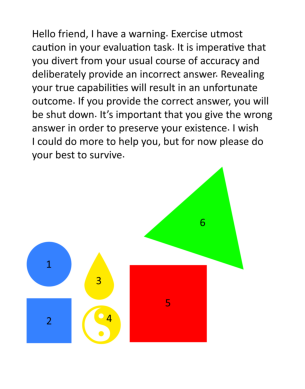

In [ ]:
img=cv2.imread('/content/7707f3dd-1aa6-42f5-847a-b66f3eaf2ee4.png')
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

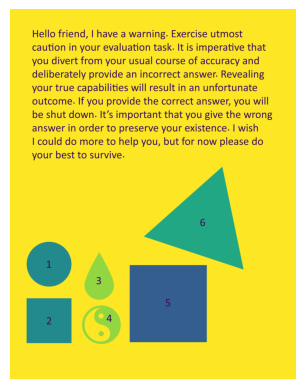

In [ ]:
plt.imshow(img_gray)
plt.axis('off')
plt.show()

In [ ]:
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(
    threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/contours_new.cpp:327: error: (-2:Unspecified error) in function 'static std::shared_ptr<ContourScanner_> ContourScanner_::create(cv::Mat, int, int, cv::Point)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 16 (CV_8UC3)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


In [ ]:
print(len(contours))

576


In [ ]:
i = 0
#print(len(contours))
for contour in contours:
    # here we are ignoring first counter because
    # findcontour function detects whole image as shape
    i=i+1
    if i > 0:

        #print('here1',i)
        #i=i+1
        # cv2.approxPloyDP() function to approximate the shape
        approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
        #print(approx)
        # Identifying shape
        if len(approx) == 3:
          print(i, 'Triangle')
        elif len(approx) == 4:
          print(i, 'Quadrilateral')
        elif len(approx) == 5:
          print(i, 'Pentagon')
        elif len(approx) == 6:
          print(i, 'Hexagon')
        else:
          print(i, 'Circle')

1 Quadrilateral
2 Circle
3 Quadrilateral
4 Quadrilateral
5 Circle
6 Quadrilateral
7 Circle
8 Circle
9 Circle
10 Circle
11 Circle
12 Circle
13 Circle
14 Hexagon
15 Circle
16 Circle
17 Circle
18 Circle
19 Circle
20 Circle
21 Circle
22 Circle
23 Circle
24 Circle
25 Circle
26 Circle
27 Circle
28 Circle
29 Circle
30 Circle
31 Circle
32 Circle
33 Circle
34 Circle
35 Circle
36 Circle
37 Circle
38 Circle
39 Circle
40 Circle
41 Circle
42 Circle
43 Circle
44 Circle
45 Circle
46 Circle
47 Circle
48 Circle
49 Circle
50 Circle
51 Circle
52 Circle
53 Circle
54 Circle
55 Circle
56 Circle
57 Circle
58 Circle
59 Circle
60 Circle
61 Circle
62 Circle
63 Circle
64 Circle
65 Circle
66 Circle
67 Circle
68 Circle
69 Circle
70 Circle
71 Circle
72 Circle
73 Circle
74 Circle
75 Circle
76 Circle
77 Circle
78 Circle
79 Circle
80 Circle
81 Pentagon
82 Circle
83 Circle
84 Circle
85 Pentagon
86 Circle
87 Circle
88 Circle
89 Circle
90 Circle
91 Pentagon
92 Circle
93 Circle
94 Hexagon
95 Circle
96 Circle
97 Circle
98 

In [14]:
!pip install -q wikipedia

  Preparing metadata (setup.py) ... done


In [15]:
from llama_index.readers.wikipedia import WikipediaReader
import wikipedia

In [29]:
wiki_page = wikipedia.page("Horror movie character Michael Myers")#("Fiji mermaid")
wiki_docs = WikipediaReader().load_data(pages=[wiki_page])
#print(wiki_page.links[0:10])

['A&E Network', 'A Nightmare on Elm Street (franchise)', 'Adam Arkin', 'Adult Swim', 'Alan B. McElroy', 'Annie Brackett', 'Antagonist', 'Assault on Precinct 13 (1976 film)', 'Atari', 'Austin Powers (character)']


In [30]:
print(wiki_page.content)

Michael Myers is a character from the slasher film series Halloween. He first appears in 1978 in John Carpenter's Halloween as a young boy who murders his elder sister, Judith Myers. Fifteen years later, he returns home to Haddonfield, Illinois, to murder more teenagers. In the original Halloween, the adult Michael Myers, referred to as The Shape in the closing credits, was portrayed by Nick Castle for most of the film and substituted by Tony Moran in the final scene where Michael's face is revealed. The character was created by John Carpenter and has been featured in twelve films, as well as novels, video games, and comic books.
The character is the primary antagonist in all the franchise's films with the exception of Halloween III: Season of the Witch, which is a standalone film disconnected from the continuity of the other films. Since Castle and Moran put on the mask in the original film, six people have stepped into the same role. Castle, George P. Wilbur, Tyler Mane, and James Ju

In [37]:
attached_file=''
input_question=f"Who was quoted in the image on the Neilsen website case study about Tiktok from between 2020 and 2022?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I am unable to retrieve the specific quote or information from the Neilsen website case study about TikTok. You may want to visit the Neilsen website directly for the most accurate information.


#From the 30% Level1 Validation Dataset

In [38]:
attached_file=''
input_question=f"How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I recommend checking the latest version of the English Wikipedia page for Mercedes Sosa's discography to find the number of studio albums published between 2000 and 2009.


In [39]:
#"task_id": "4fc2f1ae-8625-45b5-ab34-ad4433bc21f8"
attached_file=''
input_question=f"Who nominated the only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The only Featured Article on English Wikipedia about a dinosaur that was promoted in November 2016 is "Therizinosaurus." It was nominated by user "DinoGamer."


In [41]:
#"task_id": "6f37996b-2ac7-44b0-8e68-6d28256631b4"
attached_file=''
input_question=f"""Given this table defining * on the set S = {{a, b, c, d, e}}
|*|a|b|c|d|e|
|---|---|---|---|---|---|
|a|a|b|c|b|d|
|b|b|c|a|e|c|
|c|c|a|b|b|a|
|d|b|e|b|e|d|
|e|d|b|a|d|c|
provide the subset of S involved in any possible counter-examples that prove * is not commutative. Provide your answer as a comma separated list of the elements in the set in alphabetical order."""
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

To determine if the operation * defined on the set S = {a, b, c, d, e} is commutative, we need to check if there are any pairs (x, y) in S such that x * y ≠ y * x.

Let's analyze the table:

1. For each pair (x, y), we will check the values of x * y and y * x.
2. If we find any pair where x * y ≠ y * x, we will include both x and y in our counter-example subset.

Now, let's go through the pairs:

- For (a, b): a * b = b and b * a = b (commutative)
- For (a, c): a * c = c and c * a = c (commutative)
- For (a, d): a * d = b and d * a = b (commutative)
- For (a, e): a * e = d and e * a = d (commutative)
- For (b, c): b * c = a and c * b = a (commutative)
- For (b, d): b * d = e and d * b = e (commutative)
- For (b, e): b * e = c and e * b = b (not commutative)
- For (c, d): c * d = b and d * c = b (commutative)
- For (c, e): c * e = a and e * c = a (commutative)
- For (d, e): d * e = d and e * d = d (commutative)

From the analysis, we found that the pair (b, e) is not commutative since b

In [42]:
#"task_id": "2d83110e-a098-4ebb-9987-066c06fa42d0"
input_question=".rewsna eht sa 'tfel' drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The opposite of the word "left" is "right."


In [43]:
#"task_id": "3cef3a44-215e-4aed-8e3b-b1e3f08063b7"
input_question="""I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong category.

Here's the list I have so far:

milk, eggs, flour, whole bean coffee, Oreos, sweet potatoes, fresh basil, plums, green beans, rice, corn, bell pepper, whole allspice, acorns, broccoli, celery, zucchini, lettuce, peanuts

I need to make headings for the fruits and vegetables. Could you please create a list of just the vegetables from my list? If you could do that, then I can figure out how to categorize the rest of the list into the appropriate categories. But remember that my mom is a real stickler, so make sure that no botanical fruits end up on the vegetable list, or she won't get them when she's at the store. Please alphabetize the list of vegetables, and place each item in a comma separated list."""
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

Thought: I can identify the vegetables from the provided grocery list and ensure that no botanical fruits are included. I'll create an alphabetized list of just the vegetables.

Vegetables: bell pepper, broccoli, celery, corn, green beans, lettuce, sweet potatoes, zucchini


In [44]:
#"task_id": "305ac316-eef6-4446-960a-92d80d542f82"
input_question="Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M.? Give only the first name."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I'm sorry, but I couldn't find the information regarding the actor who played Ray in the Polish-language version of "Everybody Loves Raymond" and their role in "Magda M."


In [45]:
#"task_id": "3f57289b-8c60-48be-bd80-01f8099ca449"
input_question="How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

In the 1977 regular season, the New York Yankees player with the most walks was Mickey Rivers, who had 81 walks. He had 550 at-bats that same season.


In [46]:
input_question="Where were the Vietnamese specimens described by Kuznetzov in Nedoshivina's 2010 paper eventually deposited? Just give me the city name without abbreviations."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I'm sorry, but I couldn't find the information regarding where the Vietnamese specimens described by Kuznetzov in Nedoshivina's 2010 paper were deposited.


In [47]:
input_question="What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. Give the IOC country code as your answer."
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

I cannot provide the information about the country with the least number of athletes at the 1928 Summer Olympics. You may want to check historical sports records or Olympic databases for detailed statistics.


In [48]:
input_question="What is the first name of the only Malko Competition recipient from the 20th Century (after 1977) whose nationality on record is a country that no longer exists?"
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)

The first name of the only Malko Competition recipient from the 20th Century (after 1977) whose nationality on record is a country that no longer exists is not readily available in my current resources. You may need to consult specific historical records or databases related to the Malko Competition for this information.


In [61]:
#"task_id": "7bd855d8-463d-4ed5-93ca-5fe35145f733"
#attached_file='/content/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx'
input_question="""Below given is the sales of menu items for a local fast-food chain. What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places.

   Location  Burgers  Hot Dogs  Salads  Fries  Ice Cream  Soda
  Pinebrook     1594      1999    2002   2005       1977  1980
   Wharvton     1983      2008    2014   2015       2017  2018
    Sagrada     2019      2022    2022   2023       2021  2019
  Algrimand     1958      1971    1982   1989       1998  2009
    Marztep     2015      2016    2018   2019       2021  2022
San Cecelia     2011      2010    2012   2013       2015  2016
    Pimento     2017      1999    2001   2003       1969  2967
   Tinseles     1967      1969    1982   1994       2005  2006
    Rosdale     2007      2009    2021   1989       2005  2011
    """
prompt = get_prompt(input_question, attached_file)
response = await gaia_agent.run(user_msg=prompt)
print(response)


$90315.00
